# Imports

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Dataset

In [42]:
batch_size = 256
image_size = 96

# Create a new transformation that resizes the images
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Load STL-10 dataset
train_dataset = STL10(root='./data', split='train', transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(train_loader))

test_dataset = STL10(root='./data', split='test', transform=transform, download=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(test_dataset))
print(len(test_loader))

5000
20
8000
32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


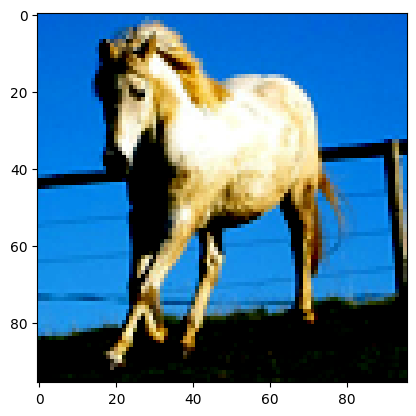

Label: 6


In [43]:
train_features, train_labels = next(iter(train_loader))

img = train_features[0].squeeze()
label = train_labels[0]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# Settings

In [44]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in discriminator
ndf = 96

# Number of training epochs
#num_epochs = 100
num_epochs = 50

# Learning rate for optimizers
lr=0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Model

In [45]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c



# Instantiate the model
netD = Discriminator(ngpu=0, dim_z=64, num_classes=10)

In [46]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(768, 64, kernel_size=(6, 6), stride=(1, 1), bias=False)
  )
  (fc): Linear(in_features=64, out_features=10, bia

# Criterion / Loss Function

In [47]:
criterion = nn.CrossEntropyLoss()

# Optimizer

In [48]:
optimizer = optim.Adam(netD.parameters(), lr=lr, weight_decay=0)

# Learning Rate Scheduler

In [ ]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training Loop

In [49]:

# set up wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="dcgan-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "DC-GAN",
    "dataset": "STL-10",
    "epochs": num_epochs,
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
# Training loop

best_acc = float('-inf')
best_model_state = None
num_train = len(train_dataset)
num_train_batches = len(train_loader)




# Set up total loss/acc trackers
all_loss = []
all_acc = []
all_correct = 0
train_running_total = 0



# Set up epochal loss/acc trackers
epoch_loss = []
epoch_acc = []


# Set up validation loss/acc trackers
val_loss = []
val_acc = []
val_running_total = 0


# Set up batch loss/acc trackers
batch_loss = []
batch_acc = []



print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # Refresh Epoch Statistics
    print('reset epoch statistics')
    epoch_correct = 0
    epoch_loss_val = 0

    
    # Set Network to Train Mode
    netD.train()

    
    # For each batch in the dataloader
    for i, (data, labels) in enumerate(train_loader, 0):
        
        # Refresh Batch Statistics
        if (i % batch_size) == 0:
            print('reset batch statistics')
            batch_correct = 0
            batch_train_loss = 0
            batch_touched = 0


        # Put train data to device (CPU, GPU, or TPU)
        real_cpu = data.to(device)

        #
        optimizer.zero_grad()
        
        # Forward pass batch through D
        output = netD(real_cpu)

        
        # Calculate loss on batch
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()
        


        # Compute Predicted Labels for a Batch in Training Dataset
        predicted = torch.argmax(output.data, dim=1).cpu()
        correct = (predicted == labels).sum().item()






        # Update All Data
        all_loss.append(loss.item())
        
        all_correct += correct
        train_running_total += labels.size(0)


        # Compute All Loss/Acc at each datapoint
        all_accuracy = all_correct / train_running_total
        all_acc.append(all_accuracy)

        print(f'iteration {i} current loss: {loss.item()} current acc: {all_accuracy}')
        
        # Log All metrics to wandb
        wandb.log({"All Loss": loss.item(), "All Accuracy": all_accuracy})




        

        # Update Epoch Data
        epoch_correct += correct
        epoch_loss_val += loss.item()
        



        

        # Update Batch Data
        batch_correct += correct
        batch_touched += labels.size(0)
        batch_train_loss += loss.item()

        # Compute Batch Loss/Acc at end of Batch
        if (i % batch_size) == (batch_size-1):
            
            batch_accuracy = batch_correct / batch_touched
            batch_acc.append(batch_accuracy)
            
            
            avg_train_batch_loss = batch_train_loss / batch_size
            batch_loss.append(avg_train_batch_loss)

            print(f'\tbatch {i % (batch_size-1)} of epoch {epoch} batch loss {avg_train_batch_loss} batch accuracy {batch_accuracy}')
            
            # Log Batch metrics to wandb
            wandb.log({"Batch Loss": avg_train_batch_loss, "Batch Accuracy": batch_accuracy})
            


    


    # Compute Epoch Loss/Acc at end of Epoch
    epoch_accuracy = epoch_correct / num_train
    epoch_acc.append(epoch_accuracy)

    avg_epoch_loss = epoch_loss_val / num_train_batches
    epoch_loss.append(avg_epoch_loss)

    print(f'\t\tEpoch {epoch}/{num_epochs} complete. Epoch loss {avg_epoch_loss} Epoch accuracy {epoch_accuracy}')
    
    # Log Epoch metrics to wandb
    wandb.log({"Epoch Loss": avg_epoch_loss, "Epoch Accuracy": epoch_accuracy})


    scheduler.step()



    # Validation Step
    print('Starting Validation Loop...')


    
    # Refresh Validation Statistics
    print('reset Validation statistics')
    val_correct = 0
    val_loss_value = 0

    
    # Set the model to valuation mode
    netD.eval()  

    
    # Iterate over the validation dataset in batches
    with torch.no_grad():
        for data, labels in test_loader:
            # Put val data to device (CPU, GPU, or TPU)
            data = data.to(device)
            labels = labels.to(device)

            
            # Forward pass batch through D
            outputs = netD(data)

            # Calculate loss on validation batch
            v_loss = criterion(outputs, labels)
            wandb.log({"Epoch val_loss": v_loss.item()}) 

            
            # Compute Predicted Labels for a Batch in Validation Dataset
            _, predicted = torch.max(outputs.data, 1)

            
            # Update Val Data
            val_loss_value += v_loss.item()
            val_running_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    
    val_accuracy = val_correct / val_running_total
    val_loss_value /= len(test_loader)
    
    val_acc.append(val_accuracy)
    val_loss.append(val_loss_value)
    
    print(f"\t\tValidation Epoch {epoch}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss_value}")


    # Log metrics to wandb
    wandb.log({"Validation Accuracy": val_acc})





    
    # Update best model if this epoch had the higest accuracy so far
    if epoch_accuracy > best_acc:
        best_acc = epoch_accuracy
        #print(f'best accuracy {best_acc}')
        best_model_state = netD.state_dict()
    
    
# Load the best model
if best_model_state is not None:
    netD.load_state_dict(best_model_state)
    print("Loaded the model with the highest accuracy.")

Starting Training Loop...
reset epoch statistics
reset batch statistics
iteration 0 current loss: 2.953791618347168 current acc: 0.11328125
iteration 1 current loss: 3.6993422508239746 current acc: 0.158203125
iteration 2 current loss: 3.179116725921631 current acc: 0.19270833333333334
iteration 3 current loss: 3.016575813293457 current acc: 0.21875
iteration 4 current loss: 2.766857147216797 current acc: 0.234375
iteration 5 current loss: 2.6920411586761475 current acc: 0.24674479166666666
iteration 6 current loss: 2.5592904090881348 current acc: 0.2533482142857143
iteration 7 current loss: 2.6981985569000244 current acc: 0.26171875
iteration 8 current loss: 2.6724421977996826 current acc: 0.2634548611111111
iteration 9 current loss: 2.2403922080993652 current acc: 0.268359375
iteration 10 current loss: 2.302535057067871 current acc: 0.26988636363636365
iteration 11 current loss: 2.101684093475342 current acc: 0.275390625
iteration 12 current loss: 2.3521745204925537 current acc: 0.27